In [5]:
import sys
sys.path.append('../../dopedefects')

import numpy as np
import data_preprocess
import model_selection
import nn
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [6]:
runs = np.load('../hyperparameter_runs/runs_y0.npy')

#### looking through data from hyperparameter tuning and picking the paramters with lowest validation error

In [7]:
test_rmse = []
for i in range(len(runs)):
    test_rmse.append(runs[i][6][1])
op_nn = np.argsort(test_rmse)[0:10]
runs[op_nn]

array([[750, 50, 32, 16, 0.05, 0.001,
        list([0.19008476383612188, 0.2876083361958325])],
       [250, 50, 32, 32, 0.05, 0.01,
        list([0.2123070520324521, 0.2889037886984004])],
       [250, 100, 32, 8, 0.05, 0.01,
        list([0.2340883219970147, 0.2922934012068678])],
       [750, 50, 32, 8, 0.05, 0.001,
        list([0.18417795581753263, 0.29393573313672383])],
       [750, 100, 32, 8, 0.05, 0.01,
        list([0.16450112315618245, 0.2961607255095735])],
       [750, 50, 32, 16, 0.1, 0.001,
        list([0.24207054192391328, 0.29929931809733457])],
       [500, 50, 32, 16, 0.05, 0.001,
        list([0.26161858248914294, 0.3023539132712318])],
       [750, 400, 16, 8, 0.05, 0.01,
        list([0.2021338665582304, 0.30261504389881017])],
       [500, 100, 32, 8, 0.05, 0.01,
        list([0.19083024958191327, 0.3039352448812679])],
       [250, 50, 32, 16, 0.05, 0.01,
        list([0.2576562361742641, 0.30411977896819237])]], dtype=object)

#### Enter path of data file stored locally here

In [ ]:
dataFile = '../../../local_dd/data.hdf5'

#### using chosen parameters on NN

#### (+3/-2)

In [9]:
seed = 7
np.random.seed(seed)

X, Y = data_preprocess.load_data(dataFile)
y = Y[:,3]
X_train, y_train, X_test, y_test, scalarX, scalarY = data_preprocess.split_and_scale(X, y)


from sklearn.ensemble import RandomForestRegressor

# RF to compare to
reg = RandomForestRegressor(max_depth=15, random_state=1, n_estimators=70, max_features=10, min_samples_leaf=5)
# reg = RandomForestRegressor(max_depth=15, random_state=1, n_estimators=100)
reg.fit(X_train, y_train.reshape(len(y_train)))
rmse = model_selection.rmse_train_test(reg, X_train, X_test, y_train, y_test, 
                       scalarX, scalarY)
print("RF", rmse)

epoch = 250
batch = 100
num_nodes1 = 16
num_nodes2 = 8
do_rate = 0.05
lr = 0.01


model = nn.nn_model(X_train, y_train, num_nodes1, num_nodes2, do_rate, lr)
model.fit(X_train, y_train, shuffle=True, epochs=epoch, batch_size=batch, verbose=0)
rmse = model_selection.rmse_train_test(model, X_train, X_test, y_train, y_test, 
                       scalarX, scalarY)

print("NN", rmse)

RF [0.21891489287617324, 0.37137469179030747]
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
NN [0.1808771431571879, 0.32994358458440204]


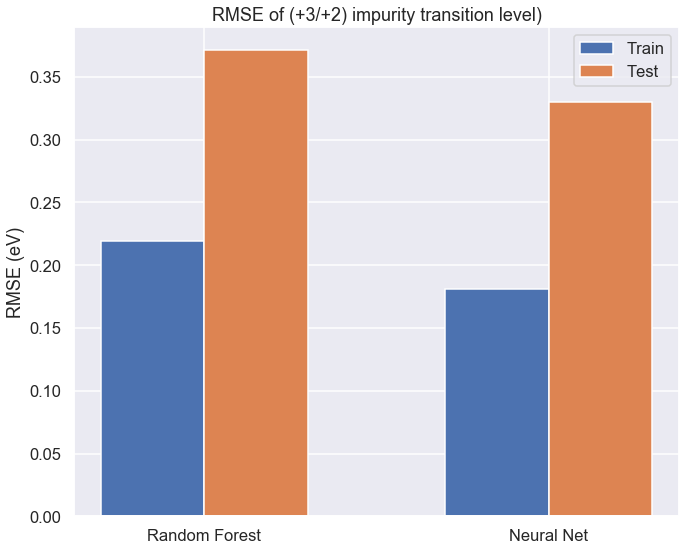

In [10]:
sns.set()
sns.set_context("talk")

x_labels = ["Random Forest", "Neural Net"]
barWidth = 0.3
r1 = np.arange(2)
r2 = [x + barWidth for x in r1]

RF = [0.21891489287617324, 0.37137469179030747]
NN = [0.1808771431571879, 0.32994358458440204]

f, axes = plt.subplots(1, 1, sharey=True, figsize=(10,8))
axes.bar(r1, [RF[0], NN[0]], width=barWidth, edgecolor='white', label='Train')
axes.bar(r2, [RF[1], NN[1]], width=barWidth, edgecolor='white', label='Test')
# axes.set_xlabel("Regression Models")
axes.set_ylabel("RMSE (eV)")
axes.set_title('RMSE of (+3/+2) impurity transition level)')
axes.set_xticks([r + barWidth/2 for r in r1])
axes.set_xticklabels(x_labels)
axes.legend()

plt.tight_layout()
plt.savefig("../fig/NN_(+3_+2)_RMSE.jpg", dpi=400)

In [12]:
sns.reset_orig()
sns.set_context("talk")

C:\Users\Linnette\AppData\Local\Continuum\miniconda3\envs\py36\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\Linnette\AppData\Local\Continuum\miniconda3\envs\py36\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


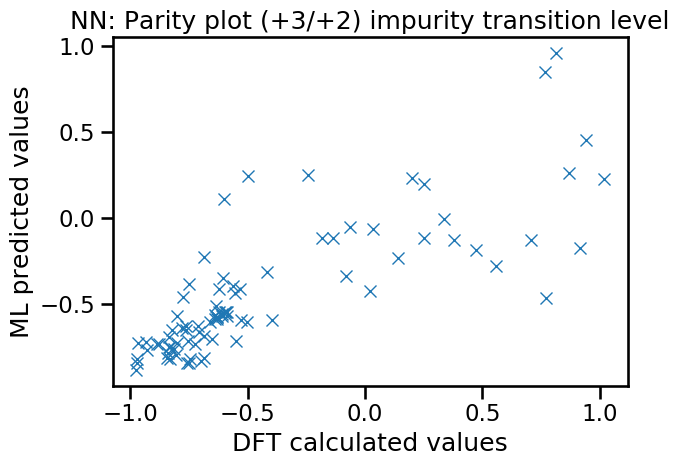

In [13]:
ypred = model.predict(X_test)
X_unscale, ypred1 = data_preprocess.data_unscale(X_test, ypred, scalarX, scalarY)
X_unscale, y_test1 = data_preprocess.data_unscale(X_test, y_test, scalarX, scalarY)
plt.figure(figsize=(7,5))
plt.plot(y_test1, ypred1, 'x')
plt.xlabel('DFT calculated values')
plt.ylabel('ML predicted values')
plt.title('NN: Parity plot (+3/+2) impurity transition level')
plt.tight_layout()
plt.savefig("../fig/NN_(+3_+2)_parity.jpg", dpi=400)

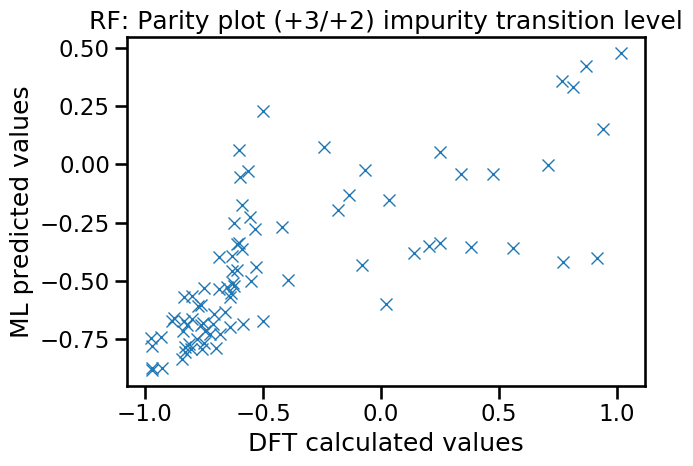

In [14]:
ypred = reg.predict(X_test)
X_unscale, ypred1 = data_preprocess.data_unscale(X_test, ypred.reshape(-1,1), scalarX, scalarY)
X_unscale, y_test1 = data_preprocess.data_unscale(X_test, y_test.reshape(-1,1), scalarX, scalarY)
plt.figure(figsize=(7,5))
plt.plot(y_test1, ypred1, 'x')
plt.xlabel('DFT calculated values')
plt.ylabel('ML predicted values')
plt.title('RF: Parity plot (+3/+2) impurity transition level')
plt.tight_layout()
plt.savefig("../fig/RF_(+3_+2)_parity.jpg", dpi=400)

### (+1/0)

In [10]:
seed = 7
np.random.seed(seed)

X, Y = data_preprocess.load_data(dataFile)
y = Y[:,5]
X_train, y_train, X_test, y_test, scalarX, scalarY = data_preprocess.split_and_scale(X, y)


from sklearn.ensemble import RandomForestRegressor

# RF to compare to
reg = RandomForestRegressor(max_depth=15, random_state=1, n_estimators=70, max_features=10, min_samples_leaf=5)
# reg = RandomForestRegressor(max_depth=15, random_state=1, n_estimators=100)
reg.fit(X_train, y_train.reshape(len(y_train)))
rmse = model_selection.rmse_train_test(reg, X_train, X_test, y_train, y_test, 
                       scalarX, scalarY)
print("RF", rmse)

epoch = 750
batch = 400
num_nodes1 = 16
num_nodes2 = 32
do_rate = 0.05
lr = 0.01


model = nn.nn_model(X_train, y_train, num_nodes1, num_nodes2, do_rate, lr)
model.fit(X_train, y_train, shuffle=True, epochs=epoch, batch_size=batch, verbose=0)
rmse = model_selection.rmse_train_test(model, X_train, X_test, y_train, y_test, 
                       scalarX, scalarY)

print("NN", rmse)

RF [0.2029685845021925, 0.24457773036165728]
NN [0.2058379166122109, 0.2513168878980707]


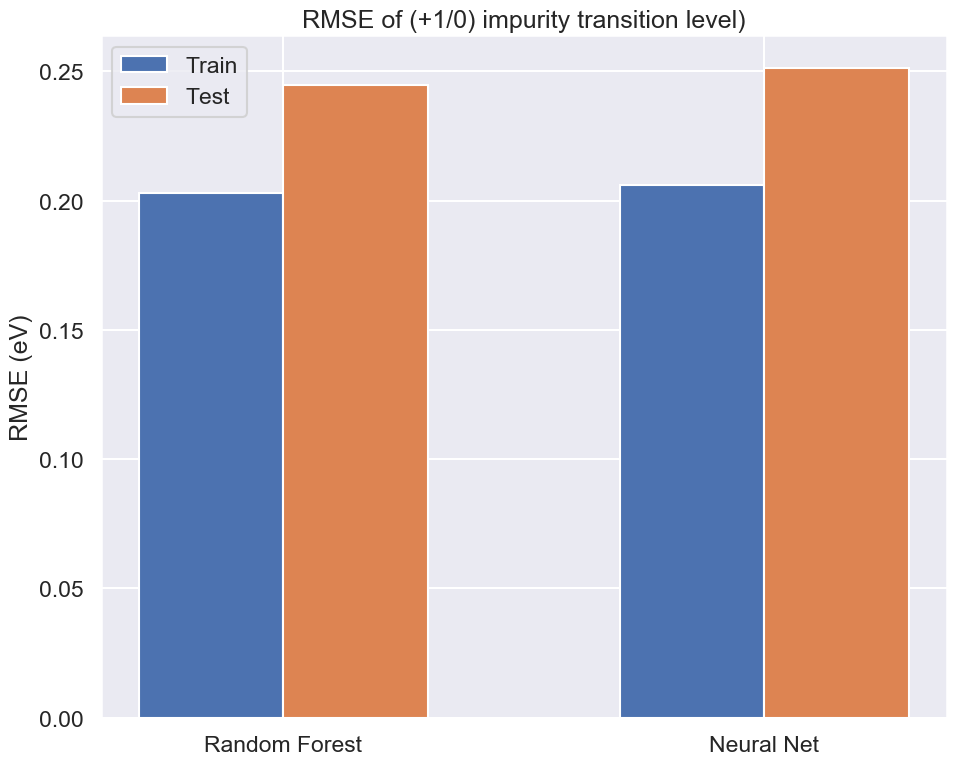

In [11]:
sns.set()
sns.set_context("talk")

x_labels = ["Random Forest", "Neural Net"]
barWidth = 0.3
r1 = np.arange(2)
r2 = [x + barWidth for x in r1]

RF = [0.2029685845021925, 0.24457773036165728]
NN = [0.2058379166122109, 0.2513168878980707]

f, axes = plt.subplots(1, 1, sharey=True, figsize=(10,8))
axes.bar(r1, [RF[0], NN[0]], width=barWidth, edgecolor='white', label='Train')
axes.bar(r2, [RF[1], NN[1]], width=barWidth, edgecolor='white', label='Test')
# axes.set_xlabel("Regression Models")
axes.set_ylabel("RMSE (eV)")
axes.set_title('RMSE of (+1/0) impurity transition level)')
axes.set_xticks([r + barWidth/2 for r in r1])
axes.set_xticklabels(x_labels)
axes.legend()

plt.tight_layout()
plt.savefig("../fig/NN_(+1_+0)_RMSE.png", dpi=400)

C:\Users\Linnette\AppData\Local\Continuum\miniconda3\envs\py36\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\Linnette\AppData\Local\Continuum\miniconda3\envs\py36\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


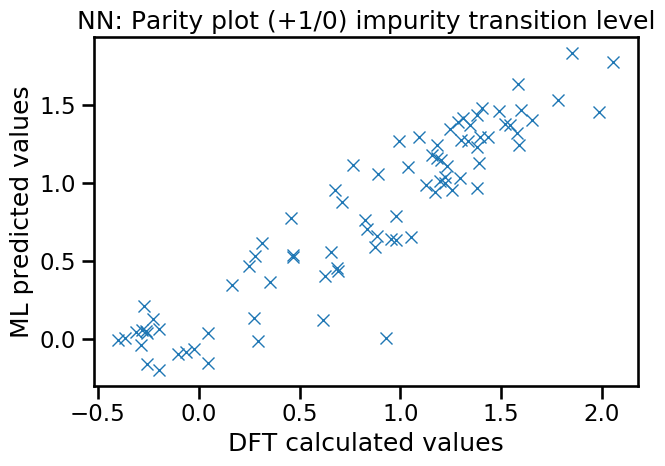

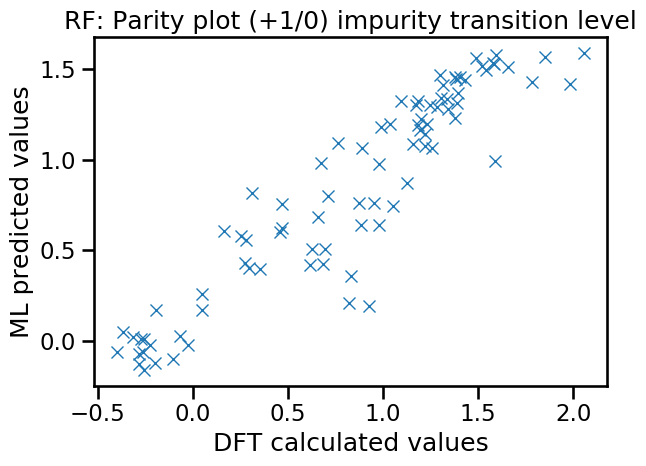

In [12]:
sns.reset_orig()
sns.set_context("talk")

ypred = model.predict(X_test)
X_unscale, ypred1 = data_preprocess.data_unscale(X_test, ypred, scalarX, scalarY)
X_unscale, y_test1 = data_preprocess.data_unscale(X_test, y_test, scalarX, scalarY)
plt.figure(figsize=(7,5))
plt.plot(y_test1, ypred1, 'x')
plt.xlabel('DFT calculated values')
plt.ylabel('ML predicted values')
plt.title('NN: Parity plot (+1/0) impurity transition level')
plt.tight_layout()
plt.savefig("../fig/NN_(+1_0)_parity.png", dpi=400)

ypred = reg.predict(X_test)
X_unscale, ypred1 = data_preprocess.data_unscale(X_test, ypred.reshape(-1,1), scalarX, scalarY)
X_unscale, y_test1 = data_preprocess.data_unscale(X_test, y_test.reshape(-1,1), scalarX, scalarY)
plt.figure(figsize=(7,5))
plt.plot(y_test1, ypred1, 'x')
plt.xlabel('DFT calculated values')
plt.ylabel('ML predicted values')
plt.title('RF: Parity plot (+1/0) impurity transition level')
plt.tight_layout()
plt.savefig("../fig/RF_(+1_0)_parity.png", dpi=400)

### (0/-1)

In [13]:
seed = 7
np.random.seed(seed)

X, Y = data_preprocess.load_data(dataFile)
y = Y[:,6]
X_train, y_train, X_test, y_test, scalarX, scalarY = data_preprocess.split_and_scale(X, y)


from sklearn.ensemble import RandomForestRegressor

# RF to compare to
reg = RandomForestRegressor(max_depth=15, random_state=1, n_estimators=70, max_features=10, min_samples_leaf=5)
# reg = RandomForestRegressor(max_depth=15, random_state=1, n_estimators=100)
reg.fit(X_train, y_train.reshape(len(y_train)))
rmse = model_selection.rmse_train_test(reg, X_train, X_test, y_train, y_test, 
                       scalarX, scalarY)
print("RF", rmse)

epoch = 750
batch = 50
num_nodes1 = 32
num_nodes2 = 8
do_rate = 0.25
lr = 0.001


model = nn.nn_model(X_train, y_train, num_nodes1, num_nodes2, do_rate, lr)
model.fit(X_train, y_train, shuffle=True, epochs=epoch, batch_size=batch, verbose=0)
rmse = model_selection.rmse_train_test(model, X_train, X_test, y_train, y_test, 
                       scalarX, scalarY)

print("NN", rmse)

RF [0.19067785139941754, 0.27783272178919444]
NN [0.15232758422137452, 0.2812853145847388]


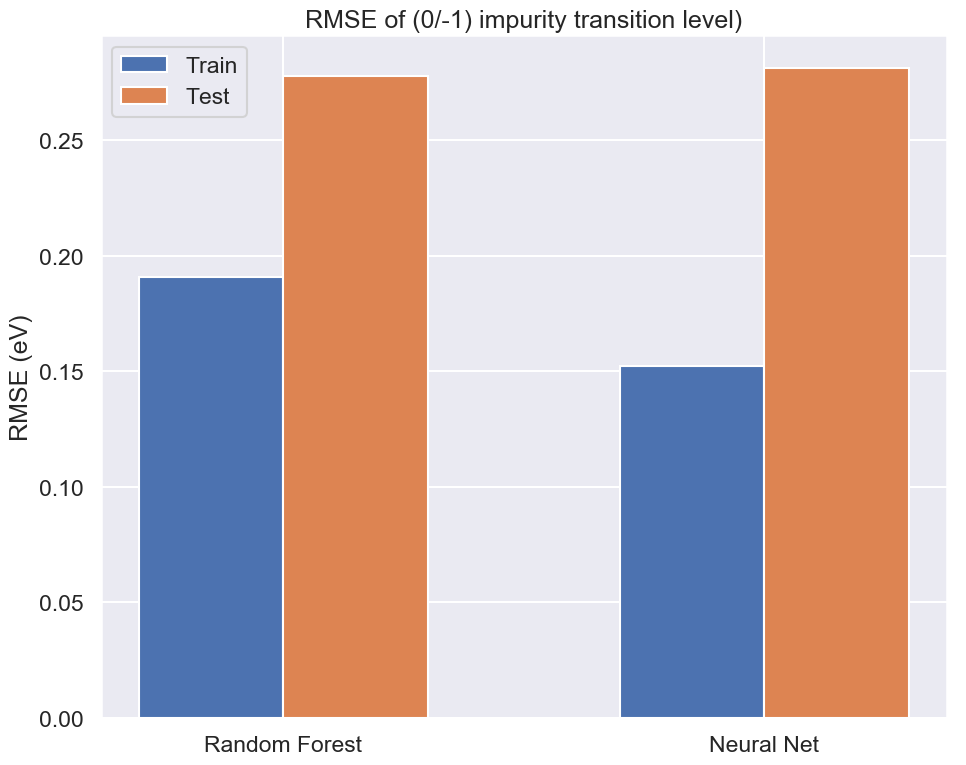

In [14]:
sns.set()
sns.set_context("talk")

x_labels = ["Random Forest", "Neural Net"]
barWidth = 0.3
r1 = np.arange(2)
r2 = [x + barWidth for x in r1]

RF = [0.19067785139941754, 0.27783272178919444]
NN = [0.15232758422137452, 0.2812853145847388]

f, axes = plt.subplots(1, 1, sharey=True, figsize=(10,8))
axes.bar(r1, [RF[0], NN[0]], width=barWidth, edgecolor='white', label='Train')
axes.bar(r2, [RF[1], NN[1]], width=barWidth, edgecolor='white', label='Test')
# axes.set_xlabel("Regression Models")
axes.set_ylabel("RMSE (eV)")
axes.set_title('RMSE of (0/-1) impurity transition level)')
axes.set_xticks([r + barWidth/2 for r in r1])
axes.set_xticklabels(x_labels)
axes.legend()

plt.tight_layout()
plt.savefig("../fig/NN_(0_-1)_RMSE.png", dpi=400)

C:\Users\Linnette\AppData\Local\Continuum\miniconda3\envs\py36\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\Linnette\AppData\Local\Continuum\miniconda3\envs\py36\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


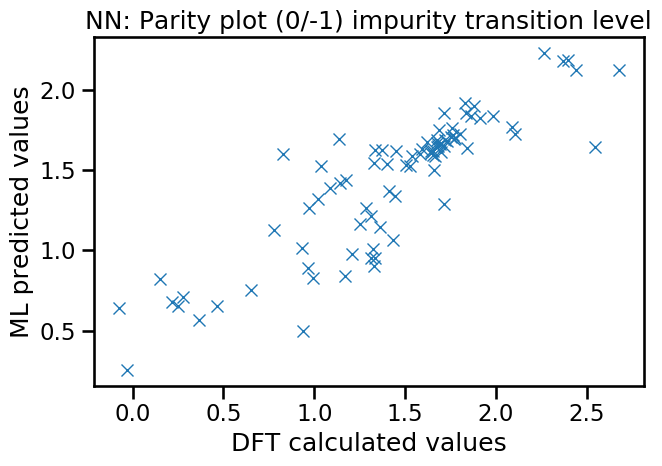

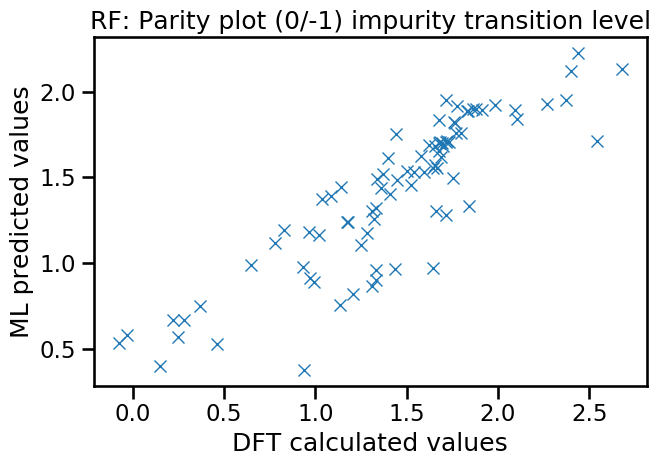

In [15]:
sns.reset_orig()
sns.set_context("talk")

ypred = model.predict(X_test)
X_unscale, ypred1 = data_preprocess.data_unscale(X_test, ypred, scalarX, scalarY)
X_unscale, y_test1 = data_preprocess.data_unscale(X_test, y_test, scalarX, scalarY)
plt.figure(figsize=(7,5))
plt.plot(y_test1, ypred1, 'x')
plt.xlabel('DFT calculated values')
plt.ylabel('ML predicted values')
plt.title('NN: Parity plot (0/-1) impurity transition level')
plt.tight_layout()
plt.savefig("../fig/NN_(0_-1)_parity.png", dpi=400)

ypred = reg.predict(X_test)
X_unscale, ypred1 = data_preprocess.data_unscale(X_test, ypred.reshape(-1,1), scalarX, scalarY)
X_unscale, y_test1 = data_preprocess.data_unscale(X_test, y_test.reshape(-1,1), scalarX, scalarY)
plt.figure(figsize=(7,5))
plt.plot(y_test1, ypred1, 'x')
plt.xlabel('DFT calculated values')
plt.ylabel('ML predicted values')
plt.title('RF: Parity plot (0/-1) impurity transition level')
plt.tight_layout()
plt.savefig("../fig/RF_(0_-1)_parity.png", dpi=400)

### delH (Cd-rich)

500, 100, 16, 32, 0.1, 0.01

In [66]:
seed = 7
np.random.seed(seed)

X, Y = data_preprocess.load_data(dataFile)
y = Y[:,0]
X_train, y_train, X_test, y_test, scalarX, scalarY = data_preprocess.split_and_scale(X, y)


from sklearn.ensemble import RandomForestRegressor

# RF to compare to
reg = RandomForestRegressor(max_depth=15, random_state=1, n_estimators=70, max_features=10, min_samples_leaf=5)
# reg = RandomForestRegressor(max_depth=15, random_state=1, n_estimators=100)
reg.fit(X_train, y_train.reshape(len(y_train)))
rmse = model_selection.rmse_train_test(reg, X_train, X_test, y_train, y_test, 
                       scalarX, scalarY)
print("RF", rmse)

epoch = 500
batch = 100
num_nodes1 = 16
num_nodes2 = 32
do_rate = 0.1
lr = 0.01


from sklearn.model_selection import train_test_split

model = nn.nn_model(X_train, y_train, num_nodes1, num_nodes2, do_rate, lr)
model.fit(X_train, y_train, shuffle=True, epochs=epoch, batch_size=batch, verbose=0)
rmse = model_selection.rmse_train_test(model, X_train, X_test, y_train, y_test, 
                       scalarX, scalarY)

print("NN", rmse)

RF [0.2968688703167868, 0.3478818375753729]
NN [0.34257564425410747, 0.35468397055656475]


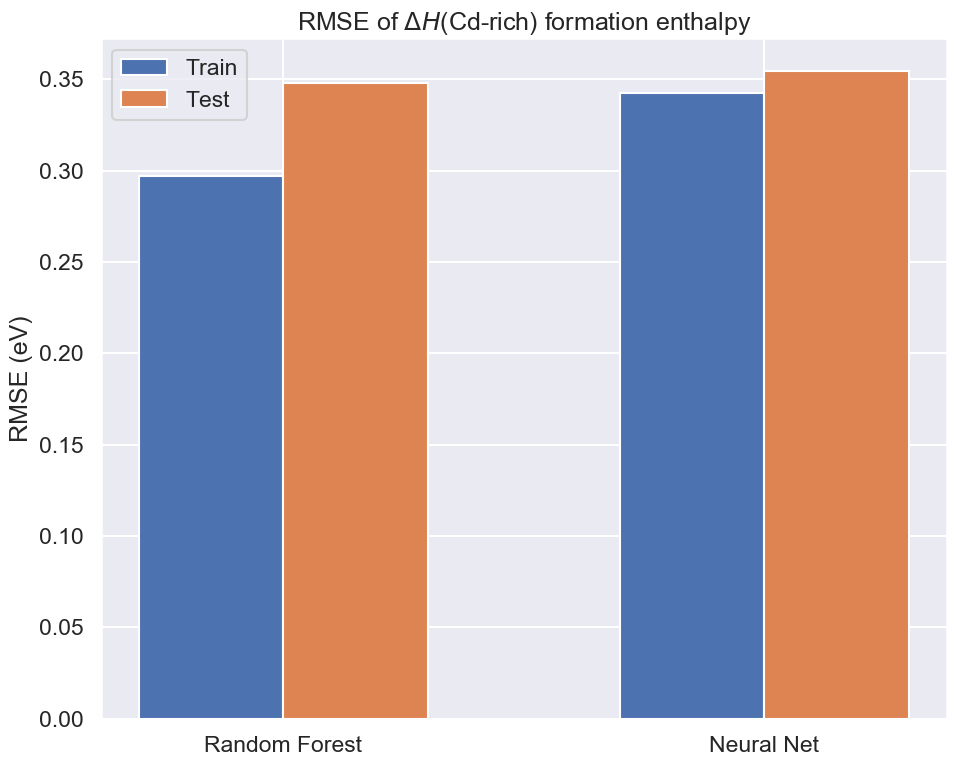

In [67]:
sns.set()
sns.set_context("talk")

x_labels = ["Random Forest", "Neural Net"]
barWidth = 0.3
r1 = np.arange(2)
r2 = [x + barWidth for x in r1]

RF = [0.2968688703167868, 0.3478818375753729]
NN = [0.34257564425410747, 0.35468397055656475]

f, axes = plt.subplots(1, 1, sharey=True, figsize=(10,8))
axes.bar(r1, [RF[0], NN[0]], width=barWidth, edgecolor='white', label='Train')
axes.bar(r2, [RF[1], NN[1]], width=barWidth, edgecolor='white', label='Test')
# axes.set_xlabel("Regression Models")
axes.set_ylabel("RMSE (eV)")
axes.set_title('RMSE of ' +'$\Delta H$' + '(Cd-rich) formation enthalpy')
axes.set_xticks([r + barWidth/2 for r in r1])
axes.set_xticklabels(x_labels)
axes.legend()

plt.tight_layout()
plt.savefig("../fig/NN_delH(Cd)_RMSE.jpg", dpi=400)

In [68]:
sns.reset_orig()
sns.set_context("talk")

C:\Users\Linnette\AppData\Local\Continuum\miniconda3\envs\py36\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\Linnette\AppData\Local\Continuum\miniconda3\envs\py36\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


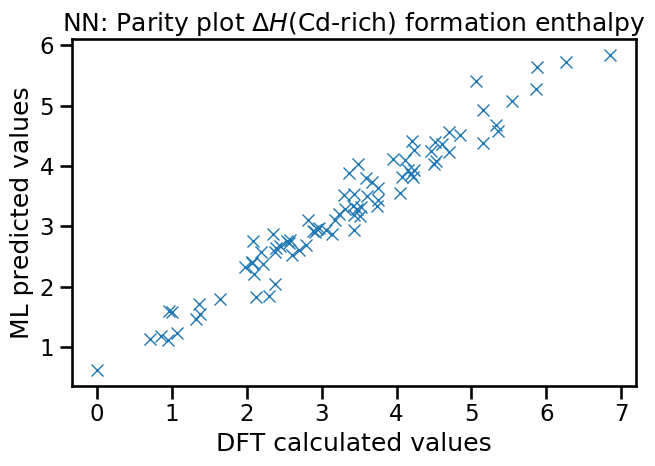

In [69]:
ypred = model.predict(X_test)
X_unscale, ypred1 = data_preprocess.data_unscale(X_test, ypred, scalarX, scalarY)
X_unscale, y_test1 = data_preprocess.data_unscale(X_test, y_test, scalarX, scalarY)
plt.figure(figsize=(7,5))
plt.plot(y_test1, ypred1, 'x')
plt.xlabel('DFT calculated values')
plt.ylabel('ML predicted values')
plt.title('NN: Parity plot ' +'$\Delta H$' + '(Cd-rich) formation enthalpy')
plt.tight_layout()
plt.savefig("../fig/NN_delH(Cd)_parity.jpg", dpi=400)

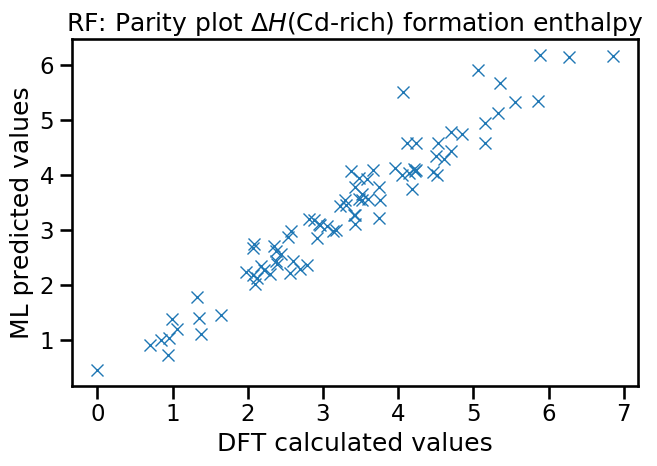

In [70]:
ypred = reg.predict(X_test)
X_unscale, ypred1 = data_preprocess.data_unscale(X_test, ypred.reshape(-1,1), scalarX, scalarY)
X_unscale, y_test1 = data_preprocess.data_unscale(X_test, y_test.reshape(-1,1), scalarX, scalarY)
plt.figure(figsize=(7,5))
plt.plot(y_test1, ypred1, 'x')
plt.xlabel('DFT calculated values')
plt.ylabel('ML predicted values')
plt.title('RF: Parity plot ' +'$\Delta H$' + '(Cd-rich) formation enthalpy')
plt.tight_layout()
plt.savefig("../fig/RF_delH(Cd)_parity.jpg", dpi=400)